# Unsupervised Anomaly Detection

Unsupervised anomaly detection using the Isolation Forest algorithm on the `payments_master.csv` dataset. The objective is to identify unusual patterns or outliers within the payment data that could indicate potential errors, process deviations, or fraudulent activities without requiring pre-labeled fraud cases.


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## 1. Data Loading and Preparation

We load the `payments_master.csv` dataset. Date columns are converted to datetime objects, and `time_to_payment` is calculated as a feature. Missing values in numerical columns are filled with the median, and categorical columns with the mode. These steps ensure the data is clean and suitable for the anomaly detection model.


In [8]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')
print(f"Data directory is set to: {data_dir}")

payment_master_path = os.path.join(data_dir, 'payments_master.csv')
fraud_case_master_path = os.path.join(data_dir, 'fraud_cases_master.csv')
research_team_master_path = os.path.join(data_dir, 'research_team_master.csv')
research_team_member_master_path = os.path.join(data_dir, 'research_team_member_master.csv')
print("************************\n")
print(f"Payment master path: {payment_master_path}")
print(f"Fraud case master path: {fraud_case_master_path}")
print(f"Research team master path: {research_team_master_path}")
print(f"Research team member master path: {research_team_member_master_path}")

Data directory is set to: c:\Users\homep\Documents\Projects\bupa_case_study\data
************************

Payment master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\payments_master.csv
Fraud case master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\fraud_cases_master.csv
Research team master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_master.csv
Research team member master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_member_master.csv


In [9]:
# Load the dataset
try:
    df_payments = pd.read_csv(payment_master_path)
except FileNotFoundError:
    print("Error: payments_master.csv not found. Please ensure the file is in the correct directory.")
    exit()

# Convert date columns to datetime objects for potential feature engineering
date_cols = ['Date received', 'Date of invoice', 'Date of authorisation', 'Payment due date', 'Date of payment']
for col in date_cols:
    if col in df_payments.columns:
        df_payments[col] = pd.to_datetime(df_payments[col], errors='coerce')

# Calculate 'time to payment' as a feature
df_payments['time_to_payment'] = (df_payments['Date of payment'] - df_payments['Date received']).dt.days

# Drop original date columns as we have 'time_to_payment'
df_payments = df_payments.drop(columns=date_cols, errors='ignore')

# Handle missing values: fill numerical with median, categorical with mode
for col in ['Invoice value', 'Payment amount', 'time_to_payment']:
    if col in df_payments.columns:
        df_payments[col].fillna(df_payments[col].median(), inplace=True)

for col in ['Research team', 'Type of expense', 'Company', 'Payment Status', 'Submitted by', 'Authorised by', 'Payment authoriser']:
    if col in df_payments.columns:
        df_payments[col].fillna(df_payments[col].mode()[0], inplace=True)

print(f"Dataset loaded with {len(df_payments)} records after preprocessing.")
print(df_payments.head())


Dataset loaded with 2000 records after preprocessing.
   Research team        Submitted by Invoice number  \
0       Genetics       Melinda White      INV-76915   
1     Immunology     Daniel Peterson      INV-64102   
2  Endocrinology       Brandy Fisher      INV-68875   
3       Oncology  Christopher Wilson      INV-20676   
4     Immunology      Amanda Johnson      INV-49709   

                                Description of spend  Invoice value  \
0  "Procured DNA extraction kits for isolating hi...       13319.94   
1  "Purchase of endotoxin-free reagents for in vi...       14696.98   
2  "Payment for mass spectrometry services to qua...       10908.06   
3  "Procured RNA extraction kits for high-through...       13541.31   
4  "Purchased Luminex multiplex assay kits for si...         524.33   

      Authorised by  Payment amount Payment authoriser Payment Status  \
0        Kevin Ross        13319.94     Antonio Wilson           Paid   
1     Sarah Collins        14696.98     An

C:\Users\homep\AppData\Local\Temp\ipykernel_16740\1982359135.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_payments[col].fillna(df_payments[col].median(), inplace=True)
C:\Users\homep\AppData\Local\Temp\ipykernel_16740\1982359135.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

## 2. Feature Selection and Preprocessing

We select a set of features that are likely to exhibit unusual patterns in the case of anomalies. These include numerical features such as 'Invoice value', 'Payment amount', and 'time_to_payment', as well as various categorical features related to the transaction details.

Similar to previous notebooks, we use `ColumnTransformer` to apply `StandardScaler` to numerical features and `OneHotEncoder` to categorical features, ensuring the data is properly scaled and encoded for the anomaly detection model.


In [10]:
features = ['Invoice value', 'Payment amount', 'time_to_payment', 
            'Research team', 'Type of expense', 'Company', 
            'Payment Status', 'Submitted by', 'Authorised by', 'Payment authoriser']

# Ensure all features exist in df_payments, filter if not
features = [f for f in features if f in df_payments.columns]

X_unsupervised = df_payments[features]

# Identify categorical and numerical features for preprocessing
categorical_features = ['Research team', 'Type of expense', 'Company', 'Payment Status', 'Submitted by', 'Authorised by', 'Payment authoriser']
numerical_features = ['Invoice value', 'Payment amount', 'time_to_payment']

# Filter to only include features actually present in the dataframe
categorical_features = [f for f in categorical_features if f in X_unsupervised.columns]
numerical_features = [f for f in numerical_features if f in X_unsupervised.columns]

# Preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor_unsupervised = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print(f"Selected {len(features)} features for unsupervised anomaly detection.")
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


Selected 10 features for unsupervised anomaly detection.
Categorical features: ['Research team', 'Type of expense', 'Company', 'Payment Status', 'Submitted by', 'Authorised by', 'Payment authoriser']
Numerical features: ['Invoice value', 'Payment amount', 'time_to_payment']


## 3. Anomaly Detection with Isolation Forest

We use the Isolation Forest algorithm, an effective unsupervised method for anomaly detection. This model works by isolating observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Repeatedly splitting the data in this way creates 'isolation trees'. Anomalies are instances that require fewer splits to be isolated.

The `contamination` parameter is set to 0.05, estimating that 5% of our data are anomalies. The model is then fitted to the preprocessed data, and anomaly scores and labels are generated. Lower anomaly scores indicate a higher likelihood of being an outlier.


In [11]:
# Define the Isolation Forest model pipeline
# contamination is the proportion of outliers in the dataset (estimate)
model_isolation_forest = Pipeline(steps=[('preprocessor', preprocessor_unsupervised),
                                         ('detector', IsolationForest(random_state=42, contamination=0.05))]) # Assuming 5% outliers

# Fit the model and make predictions (anomaly scores and labels)
model_isolation_forest.fit(X_unsupervised)

anomaly_scores = model_isolation_forest.decision_function(X_unsupervised)
anomaly_predictions = model_isolation_forest.predict(X_unsupervised) # -1 for outliers, 1 for inliers

df_payments['anomaly_score'] = anomaly_scores
df_payments['is_anomaly'] = anomaly_predictions

outliers_unsupervised = df_payments[df_payments['is_anomaly'] == -1]

print(f"\n--- Unsupervised Anomaly Detection (Isolation Forest) ---")
print(f"Identified {len(outliers_unsupervised)} anomalies using Isolation Forest (assuming 5% contamination).")
print("\nTop 10 anomalies (lowest anomaly score):")
print(outliers_unsupervised.sort_values(by='anomaly_score').head(10)[['Invoice number', 'Invoice value', 'time_to_payment', 'anomaly_score']])



--- Unsupervised Anomaly Detection (Isolation Forest) ---
Identified 100 anomalies using Isolation Forest (assuming 5% contamination).

Top 10 anomalies (lowest anomaly score):
     Invoice number  Invoice value  time_to_payment  anomaly_score
276       INV-92598        3601.59             19.0      -0.019247
173       INV-59664        3703.89             19.0      -0.016396
915       INV-76994         993.08             17.0      -0.012411
1516      INV-92840        4329.24             19.0      -0.012269
820       INV-20043        4970.75             19.0      -0.011822
181       INV-49273        3414.86             25.0      -0.011220
697       INV-99639        1514.00             22.0      -0.010958
1243      INV-76075        3973.68             19.0      -0.010942
1638      INV-92058        1413.77             19.0      -0.010880
1935      INV-21661        4206.95             29.0      -0.010846


## 4. Visualization

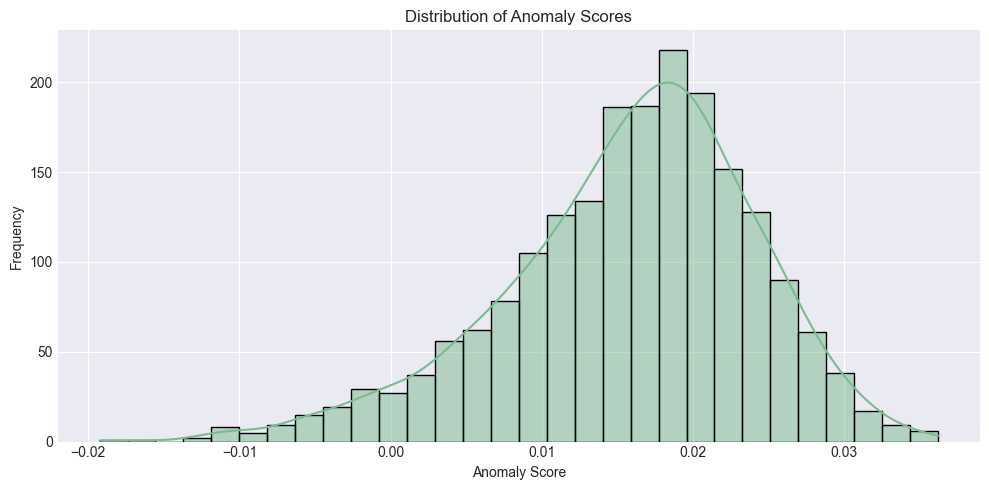

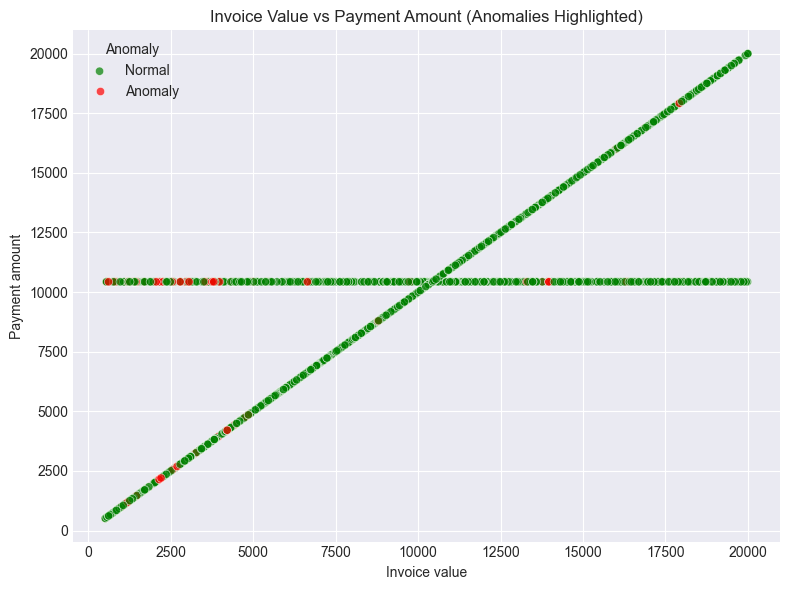

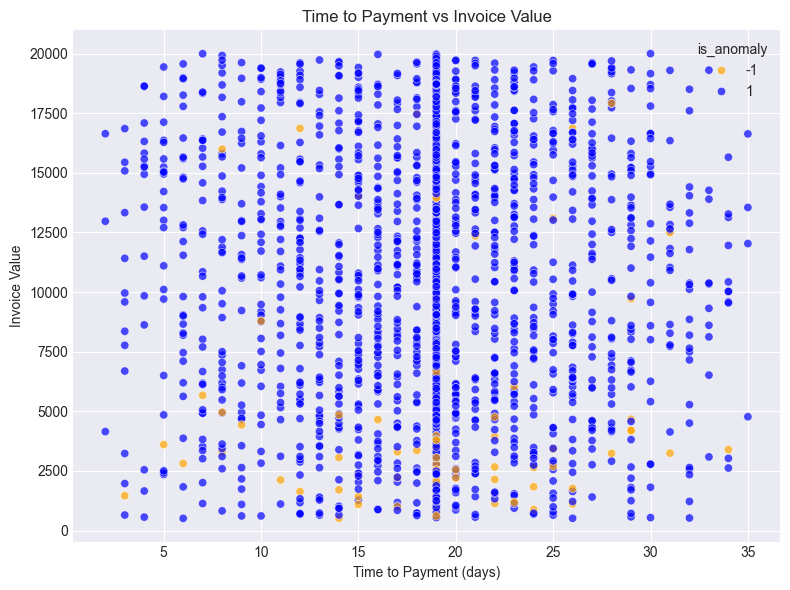

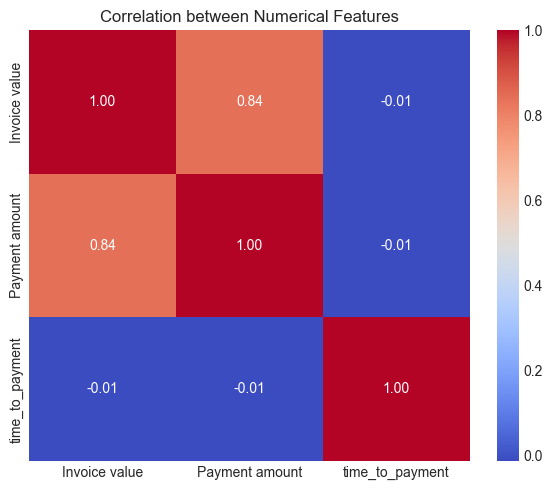

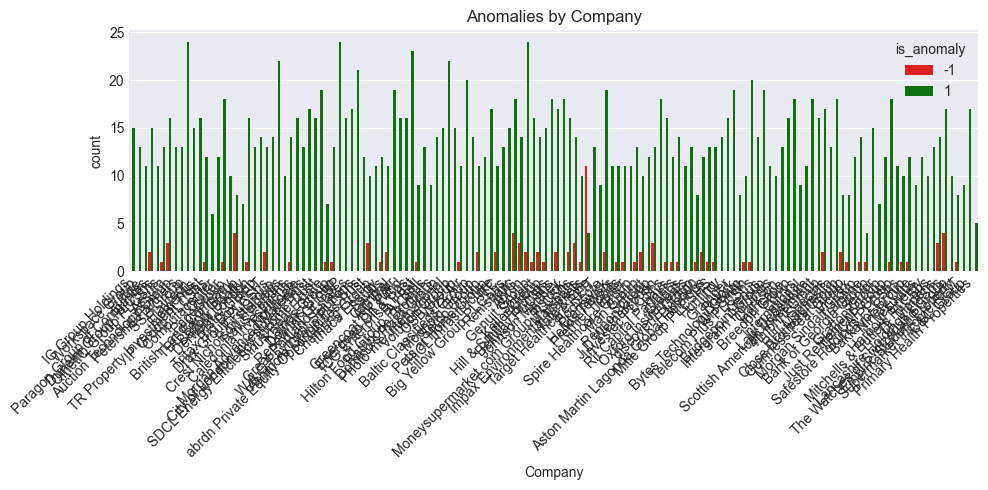

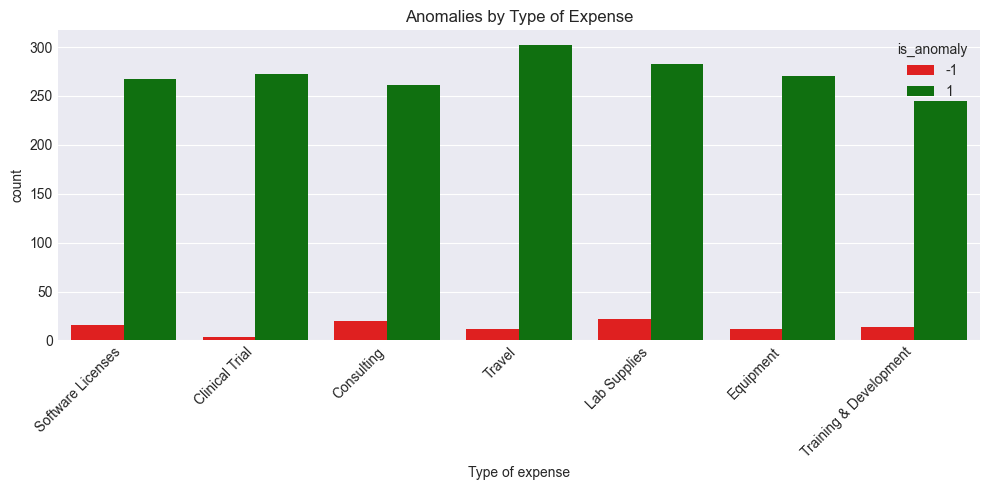

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("crest")

# Anomaly score distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_payments['anomaly_score'], bins=30, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter plot: Invoice value vs Payment amount
if {'Invoice value', 'Payment amount'}.issubset(df_payments.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_payments,
        x='Invoice value',
        y='Payment amount',
        hue='is_anomaly',
        palette={1: 'green', -1: 'red'},
        alpha=0.7
    )
    plt.title('Invoice Value vs Payment Amount (Anomalies Highlighted)')
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    plt.tight_layout()
    plt.show()

# Time to Payment vs Invoice Value (to detect delay-related anomalies)
if {'time_to_payment', 'Invoice value'}.issubset(df_payments.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_payments,
        x='time_to_payment',
        y='Invoice value',
        hue='is_anomaly',
        palette={1: 'blue', -1: 'orange'},
        alpha=0.7
    )
    plt.title('Time to Payment vs Invoice Value')
    plt.xlabel('Time to Payment (days)')
    plt.ylabel('Invoice Value')
    plt.tight_layout()
    plt.show()

# Feature importance proxy: correlation heatmap
if len(numerical_features) > 1:
    plt.figure(figsize=(6, 5))
    corr = df_payments[numerical_features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation between Numerical Features')
    plt.tight_layout()
    plt.show()

# Count of anomalies by company or type of expense
if 'Company' in df_payments.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_payments, x='Company', hue='is_anomaly', palette={1: 'green', -1: 'red'})
    plt.title('Anomalies by Company')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if 'Type of expense' in df_payments.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_payments, x='Type of expense', hue='is_anomaly', palette={1: 'green', -1: 'red'})
    plt.title('Anomalies by Type of Expense')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()